In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
sys.path.append('./../lung_cancer')
from radio.preprocessing import CTImagesMaskedBatch as CTIMB
from radio.preprocessing.mip import numba_xip
from radio.models import DenseNoduleNet
from radio.dataset import Dataset, FilesIndex, F, V, B
from radio.dataset.models.tf import UNet
from radio.dataset.models.tf.losses import dice_batch, dice

Using TensorFlow backend.


In [3]:
sys.path.append('./../lung_cancer/tutorials')
import utils

In [4]:
PATH = './blosc/*'
luna_index = FilesIndex(path=PATH, dirs=True, no_ext=False)
luna_dataset = Dataset(index=luna_index, batch_class=CTIMB)
luna_dataset.cv_split(0.9, shuffle=True)

In [5]:
luna_dataset.indices.shape

(888,)

In [6]:
nodules_df = pd.read_csv('/notebooks/data/CT/luna/annotations.csv')
nodules_df.head(2)

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708


In [7]:
def logloss(labels, predictions):
    e = 1e-15
    #labels = tf.to_float(labels)
    #predictions = tf.to_float(predictions)
    #print(labels.dtype, predictions.dtype)
    loss = 100 * labels * tf.log(predictions + e) + (1 - labels) * tf.log(1 - predictions + e)
    loss = tf.reduce_mean(-loss)
    tf.losses.add_loss(loss)
    return loss

In [8]:
config = dict(
    inputs=dict(
        images=dict(shape=(256, 256, 1)),
        masks=dict(shape=(256, 256, 1), name='targets')
    ),
    input_block=dict(inputs='images'),
    #body=dict(filters=[16, 32, 64, 128]),
    body=dict(filters=[8, 16, 32, 64]),
    #loss=dice, output=dict(ops='sigmoid'),
    #loss='bce', output=dict(ops='sigmoid'),
    loss=logloss, output=dict(predictions='sigmoid'),
    optimizer=dict(use_locking=True),
    session=dict(config=tf.ConfigProto(gpu_options=tf.GPUOptions(visible_device_list="7"))),
)

In [9]:
def prep1(batch, component):
    images = batch.unpack(component=component, data_format=None)
    new_images = []
    for i in range(images.shape[0]):
        new_image = numba_xip(images[i], 8, 0, 8)
        new_images.append(new_image)
    new_images = np.stack(new_images)
    new_images = new_images.reshape((-1,) + new_images.shape[2:] + (1,))
    return new_images
    
def prep(batch):
    batch.nimages = prep1(batch, 'images')    
    batch.nmasks = prep1(batch, 'masks')

In [10]:
def train(batch):
    k = 8
    model = batch.pipeline.get_model_by_name('net')
    predictions = []
    for i in range(len(batch.nimages) // k):
        loss, preds = model.train(fetches=['loss', 'predictions'], feed_dict={
            'images': batch.nimages[i*k:i*k+k],
            'masks': batch.nmasks[i*k:i*k+k],
        })
        batch.pipeline.set_variable('loss', loss)
        predictions.append(preds)
    predictions = np.stack(predictions).reshape((-1,) + predictions[0].shape)
    batch.pipeline.set_variable('predictions', predictions)

In [11]:
training_pipeline = (
    luna_dataset.train.p
      .init_variable('loss')
      .init_variable('predictions')
      .load(fmt='blosc')
      .init_model('dynamic', UNet, 'net', config)
      .call(prep)
      .call(train)
)

In [92]:
training_pipeline.run(batch_size=4, n_epochs=5, shuffle=True, bar=True, prefetch=0)

100%|█████████▉| 998/999 [1:03:49<00:03,  3.94s/it]


In [90]:
model = training_pipeline.get_model_by_name('net')

In [91]:
model.save('unet_mip')

In [89]:
training_pipeline.get_variable('loss')

0.006027179

In [93]:
batch = training_pipeline.next_batch(batch_size=1)
mips, targets, predictions = batch.nimages, batch.nmasks, batch.pipeline.get_variable('predictions')
predictions = predictions.reshape((-1,) + predictions.shape[2:])
preds = predictions[:]
preds[preds < .5] = 0

In [94]:
np.unique(np.where(batch.masks > 0)[0])

array([ 92,  93,  94, 105, 106, 107, 108])

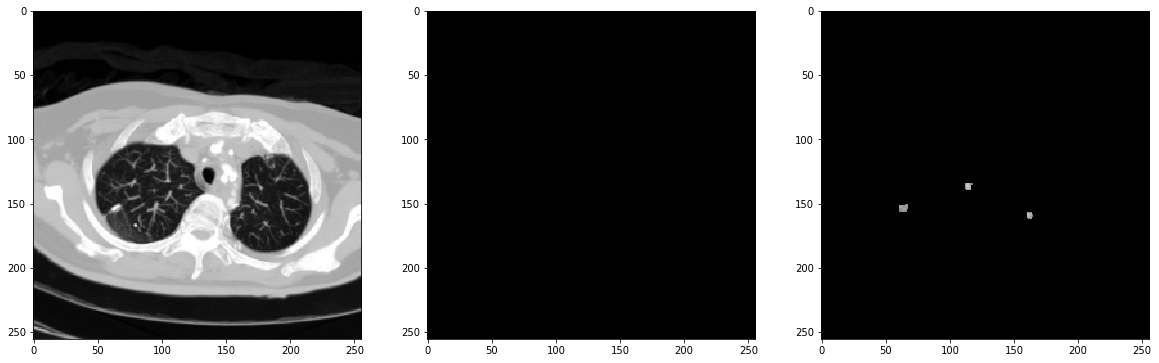

In [99]:
k = 15
fig,ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(mips[k, :,:, 0], clim=(0, 255), cmap=plt.cm.gray)
ax[1].imshow(targets[k, :,:,0], clim=(0,1), cmap=plt.cm.gray)
ax[2].imshow(predictions[k,:,:,0], clim=(0,1), cmap=plt.cm.gray)

# Testing

In [100]:
testing_pipeline = (
    luna_dataset.test.p
      .import_model('net', training_pipeline)
      .init_variables(['predictions'])
      .load(fmt='blosc')
      .call(prep)
      .predict_model('net', fetches='predictions', feed_dict={
          'images': B('nimages'),
          'masks': B('nmasks'),
      }, save_to=V('predictions'))
)

In [101]:
batch = testing_pipeline.next_batch(batch_size=1)

In [102]:
np.unique(np.where(batch.masks > 0)[0])

array([76, 77, 78, 79, 80, 81, 82])

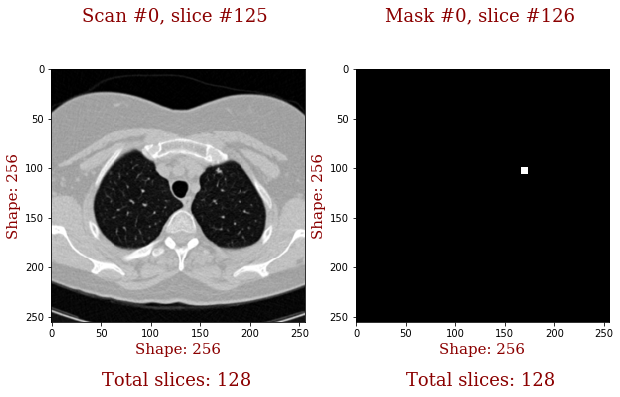

In [56]:
k = 125
utils.show_slices(batch, scan_indices=[0, 0], ns_slice=[k, k+1], components=['images', 'masks'], clims=[(0, 255), (0, 1)], grid=False)

In [103]:
targets, mips, predictions = batch.nmasks, batch.nimages, testing_pipeline.get_variable('predictions')
predictions[predictions < .5] = 0

In [104]:
np.unique(np.where(predictions > 0.5)[0])

array([ 3,  4,  5,  6,  9, 10, 11, 12, 13, 14])

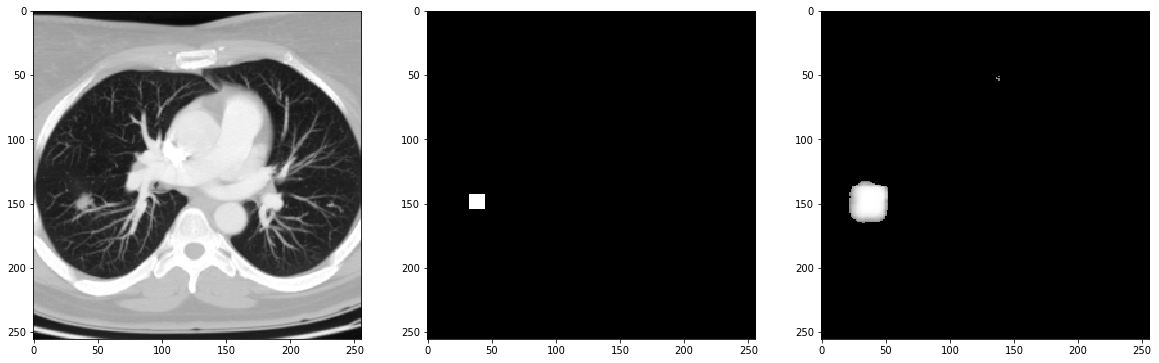

In [110]:
k = 9
fig,ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(mips[k, :,:, 0], clim=(0, 255), cmap=plt.cm.gray)
ax[1].imshow(targets[k, :,:,0], clim=(0,1), cmap=plt.cm.gray)
ax[2].imshow(predictions[k,:,:,0], clim=(0,1), cmap=plt.cm.gray)